In [1]:
'''
This file calculates the beta for all S&P500 stocks, calculates their expected return and 
tries to create a momentum and mean reversion strategy based on the expected returns vs realized returns.

It also transforms and downloads the calculated betas and risk free rates (One column for beta and one for risk free). 

Import tickers for all S&P500 from Wikipedia
Download data from Yahoo Finance
For calculating beta, we only need the close price
Calculate the daily change in stock price from the daily close price
Calculate the rolling beta using daily change
Add in US6M rate to use as risk free rate
Calculate the Expected Returns for every stock, using the 1 year realized market returns as expected market returns
Calculate the Realized Returns for every stock over the past 1 year

Create a momentum strategy of going long the stocks with highest realized returns + expected returns
Results are in df8

Create a mean reversion strategy of going long the stocks with highest expected returns minus realized returns
Results are in df10

#df contains raw data downloaded from yfinance
#df1 contains close data for all S&P 500 stocks and the index
#df2 contains the daily return data for all S&P 500 stocks and the index
#df3 contains the calculated betas
#df4 contains the beta for all S&P 500 stocks, S&P return and US6M rate
#df5 contains the expected return for all S&P 500 stocks
#df6 contains the actual returns over the past 1 year
#df7 adds the expected returns to the 1 year historical realized returns
#df8 ranks every day the stock with the highest expected returns +realized returns
#df9 subtracts the 1 year historical realized returns from the expected returns
#df10 ranks every day the stock with the highest expected returns -realized returns
'''

'\nThis file calculates the beta for all S&P500 stocks, calculates their expected return and \ntries to create a momentum and mean reversion strategy based on the expected returns vs realized returns.\n\nImport tickers for all S&P500 from Wikipedia\nDownload data from Yahoo Finance\nFor calculating beta, we only need the close price\nCalculate the daily change in stock price from the daily close price\nCalculate the rolling beta using daily change\nAdd in US6M rate to use as risk free rate\nCalculate the Expected Returns for every stock, using the 1 year realized market returns as expected market returns\nCalculate the Realized Returns for every stock over the past 1 year\n\nCreate a momentum strategy of going long the stocks with highest realized returns + expected returns\nResults are in df8\n\nCreate a mean reversion strategy of going long the stocks with highest expected returns minus realized returns\nResults are in df10\n\n#df contains raw data downloaded from yfinance\n#df1 cont

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycaret

# Yahoo finance
import yfinance as yf

# Datetime
import datetime as dt
from datetime import datetime

In [3]:
start=pd.to_datetime('1990-01-01', format='%Y-%m-%d')
today_date = datetime.today().strftime('%Y-%m-%d')
period=256           #lookback period for calculation of beta, realized returns

In [4]:
#Download data for multiple indicators available on Yahoo Finance

# Read and print the stock tickers that make up S&P500
tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol']
tickers=tickers.to_list()

print(tickers)
#print(tickers.head())



['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'C

In [5]:
#Two of the tickers have issue, also adding in S&P 500 index
for i in range(len(tickers)):
 
    # replace BF.B with BF-B
    if tickers[i] == 'BF.B':
        tickers[i] = 'BF-B'
 
    # replace BRK.B with BRK-B
    if tickers[i] == 'BRK.B':
        tickers[i] = 'BRK-B'

#Add S&P index
tickers.append("^GSPC")

# print list
print(tickers)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK-B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF-B', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'C

In [6]:
tickers = yf.Tickers(tickers)

In [7]:
df = tickers.download(start=start,end=today_date,interval='1D',)   #['Adj Close']
#df contains raw data downloaded from yfinance
df

[*********************100%%**********************]  504 of 504 completed


Price            Close                                                         \
Ticker               A    AAL        AAPL        ABBV        ABNB         ABT   
Date                                                                            
1990-01-02         NaN    NaN    0.262721         NaN         NaN    1.809340   
1990-01-03         NaN    NaN    0.264485         NaN         NaN    1.815872   
1990-01-04         NaN    NaN    0.265367         NaN         NaN    1.812607   
1990-01-05         NaN    NaN    0.266249         NaN         NaN    1.793012   
1990-01-08         NaN    NaN    0.268012         NaN         NaN    1.802203   
...                ...    ...         ...         ...         ...         ...   
2024-06-05  133.559998  11.62  195.869995  165.440002  145.779999  103.230003   
2024-06-06  132.820007  11.43  194.479996  168.570007  147.000000  104.269997   
2024-06-07  132.979996  11.50  196.889999  169.419998  146.660004  107.580002   
2024-06-10  133.029999  11.49  193.119995  170.460007  148.070007  107.489998   
2024-06-11  132.110001  11.28  207.149994  167.699997  147.750000  105.809998   

Price                                                       ...   Volume  \
Ticker            ACGL         ACN        ADBE         ADI  ...       WY   
Date                                                        ...            
1990-01-02         NaN         NaN    1.188340    1.007657  ...   442400   
1990-01-03         NaN         NaN    1.247024    0.955311  ...   289700   
1990-01-04         NaN         NaN    1.305707    0.942224  ...   324200   
1990-01-05         NaN         NaN    1.335049    0.942224  ...   214000   
1990-01-08         NaN         NaN    1.352692    0.942224  ...   275400   
...                ...         ...         ...         ...  ...      ...   
2024-06-05   99.680000  291.019989  455.799988  235.679993  ...  2472400   
2024-06-06  100.080002  291.739990  458.130005  237.410004  ...  4555100   
2024-06-07  100.570000  288.399994  465.429993  234.770004  ...  3397900   
2024-06-10  100.580002  290.429993  459.940002  235.369995  ...  4424000   
2024-06-11   99.580002  294.220001  462.690002  236.300003  ...  3095809   

Price                                                                      \
Ticker           WYNN      XEL       XOM        XYL        YUM        ZBH   
Date                                                                        
1990-01-02        NaN   247200   5326000        NaN        NaN        NaN   
1990-01-03        NaN   126800   4980400        NaN        NaN        NaN   
1990-01-04        NaN   204200   6013200        NaN        NaN        NaN   
1990-01-05        NaN   144800   3854800        NaN        NaN        NaN   
1990-01-08        NaN   189000   4302000        NaN        NaN        NaN   
...               ...      ...       ...        ...        ...        ...   
2024-06-05  1335000.0  2474900  14863500   973500.0  1944000.0   918100.0   
2024-06-06  1194600.0  2395000  13154100  1190300.0  1528900.0   902300.0   
2024-06-07  1416200.0  3824500  13289200   873900.0  1467100.0  1070300.0   
2024-06-10  1395500.0  4067900  15245200  1304100.0  1717000.0  1214500.0   
2024-06-11  1933040.0  2740482  12413991   634187.0  2141943.0  2761086.0   

Price                                        
Ticker          ZBRA        ZTS       ^GSPC  
Date                                         
1990-01-02       NaN        NaN   162070000  
1990-01-03       NaN        NaN   192330000  
1990-01-04       NaN        NaN   177000000  
1990-01-05       NaN        NaN   158530000  
1990-01-08       NaN        NaN   140110000  
...              ...        ...         ...  
2024-06-05  248000.0  1870800.0  3591460000  
2024-06-06  162800.0  2722200.0  3609990000  
2024-06-07  187300.0  1819400.0  3692760000  
2024-06-10  227800.0  2506900.0  3622280000  
2024-06-11  166872.0  1843969.0  2348465000  

[8677 rows x 3528 columns]

In [8]:
list(df.columns.levels[0])

['Close', 'Dividends', 'High', 'Low', 'Open', 'Stock Splits', 'Volume']

In [9]:
df1=df['Close']

In [10]:
#df1 contains close data for all S&P 500 stocks and the index
df1

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,0.262721,NaN,NaN,1.809340,NaN,NaN,1.188340,1.007657,...,3.252946,NaN,4.096442,3.929669,NaN,NaN,NaN,NaN,NaN,359.690002
1990-01-03,NaN,NaN,0.264485,NaN,NaN,1.815872,NaN,NaN,1.247024,0.955311,...,3.181294,NaN,4.083797,3.890371,NaN,NaN,NaN,NaN,NaN,358.760010
1990-01-04,NaN,NaN,0.265367,NaN,NaN,1.812607,NaN,NaN,1.305707,0.942224,...,3.152635,NaN,3.982653,3.851074,NaN,NaN,NaN,NaN,NaN,355.670013
1990-01-05,NaN,NaN,0.266249,NaN,NaN,1.793012,NaN,NaN,1.335049,0.942224,...,3.138305,NaN,3.944723,3.831427,NaN,NaN,NaN,NaN,NaN,352.200012
1990-01-08,NaN,NaN,0.268012,NaN,NaN,1.802203,NaN,NaN,1.352692,0.942224,...,3.138305,NaN,3.906791,3.890371,NaN,NaN,NaN,NaN,NaN,353.790009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-05,133.559998,11.62,195.869995,165.440002,145.779999,103.230003,99.680000,291.019989,455.799988,235.679993,...,29.450001,93.360001,55.160000,113.120003,139.669998,140.529999,112.639999,307.500000,175.820007,5354.029785
2024-06-06,132.820007,11.43,194.479996,168.570007,147.000000,104.269997,100.080002,291.739990,458.130005,237.410004,...,29.760000,92.480003,54.820000,113.970001,136.869995,140.830002,113.370003,307.489990,176.779999,5352.959961
2024-06-07,132.979996,11.50,196.889999,169.419998,146.660004,107.580002,100.570000,288.399994,465.429993,234.770004,...,29.360001,93.139999,54.740002,112.750000,137.320007,139.970001,113.339996,300.829987,176.919998,5346.990234


In [11]:
#Calculate the daily returns
df2 = np.log(df1/df1.shift(1))

In [12]:
#df2 contains the daily return data for all S&P 500 stocks and the index
df2

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,NaN,NaN,0.006689,NaN,NaN,0.003603,NaN,NaN,0.048202,-0.053346,...,-0.022273,NaN,-0.003091,-0.010051,NaN,NaN,NaN,NaN,NaN,-0.002589
1990-01-04,NaN,NaN,0.003331,NaN,NaN,-0.001799,NaN,NaN,0.045985,-0.013793,...,-0.009049,NaN,-0.025079,-0.010152,NaN,NaN,NaN,NaN,NaN,-0.008650
1990-01-05,NaN,NaN,0.003316,NaN,NaN,-0.010869,NaN,NaN,0.022223,0.000000,...,-0.004556,NaN,-0.009569,-0.005115,NaN,NaN,NaN,NaN,NaN,-0.009804
1990-01-08,NaN,NaN,0.006601,NaN,NaN,0.005113,NaN,NaN,0.013129,0.000000,...,0.000000,NaN,-0.009662,0.015267,NaN,NaN,NaN,NaN,NaN,0.004504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-05,0.020499,0.010381,0.007790,0.020148,-0.008878,-0.001936,-0.011768,0.010223,0.016435,0.021660,...,-0.000679,0.004724,-0.015649,0.003986,0.018572,-0.007161,-0.007077,0.015502,0.022664,0.011778
2024-06-06,-0.005556,-0.016486,-0.007122,0.018743,0.008334,0.010024,0.004005,0.002471,0.005099,0.007314,...,0.010471,-0.009471,-0.006183,0.007486,-0.020251,0.002133,0.006460,-0.000033,0.005445,-0.000200
2024-06-07,0.001204,0.006106,0.012316,0.005030,-0.002316,0.031251,0.004884,-0.011515,0.015809,-0.011182,...,-0.013532,0.007111,-0.001460,-0.010762,0.003282,-0.006125,-0.000265,-0.021897,0.000792,-0.001116


In [13]:
#create a df3 to store the betas
#specify the lookback periods to calculate betas

df3=df2.copy()


In [14]:
#Loop through all the columns, then loop through all the rows (starting from period). Calculate for the period what is the beta and put it in df3

for j in range (df2.shape[1]-1):
    for i in range(1+period, len(df2)):
        try:
            s = df2.iloc[i-period:i,j] 
            m = df2.iloc[i-period:i,-1]  #check if SP500 is in last column or second last column of df2
            covariance = np.cov(s,m) 
            beta = covariance[0,1]/covariance[1,1]
            df3.iloc[i,j]= beta
        except IndexError:
            df3.iloc[i,j]= 0

In [15]:
#df3 contains the beta for all S&P 500 stocks
df3

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,NaN,NaN,0.006689,NaN,NaN,0.003603,NaN,NaN,0.048202,-0.053346,...,-0.022273,NaN,-0.003091,-0.010051,NaN,NaN,NaN,NaN,NaN,-0.002589
1990-01-04,NaN,NaN,0.003331,NaN,NaN,-0.001799,NaN,NaN,0.045985,-0.013793,...,-0.009049,NaN,-0.025079,-0.010152,NaN,NaN,NaN,NaN,NaN,-0.008650
1990-01-05,NaN,NaN,0.003316,NaN,NaN,-0.010869,NaN,NaN,0.022223,0.000000,...,-0.004556,NaN,-0.009569,-0.005115,NaN,NaN,NaN,NaN,NaN,-0.009804
1990-01-08,NaN,NaN,0.006601,NaN,NaN,0.005113,NaN,NaN,0.013129,0.000000,...,0.000000,NaN,-0.009662,0.015267,NaN,NaN,NaN,NaN,NaN,0.004504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-05,0.923434,1.437444,1.033126,0.328691,1.674634,0.413529,0.300921,0.958756,1.548789,1.367786,...,0.944638,1.145825,0.341308,0.276797,0.980229,0.672899,0.734113,1.533333,1.137975,0.011778
2024-06-06,0.930193,1.435287,1.030719,0.341071,1.651551,0.407366,0.287523,0.959886,1.548583,1.372798,...,0.936219,1.138640,0.325550,0.276622,0.985771,0.659512,0.721459,1.532795,1.144689,-0.000200
2024-06-07,0.924363,1.448397,1.034854,0.346260,1.669291,0.409471,0.276119,0.958895,1.554493,1.377511,...,0.940173,1.139395,0.337049,0.267014,0.999376,0.665376,0.727644,1.527629,1.155212,-0.001116


In [16]:
#To download the daily betas for S&P 500

#df3.to_csv(path_or_buf='/Users/bennyang/Downloads/S&P500 betas.csv', index=True)  

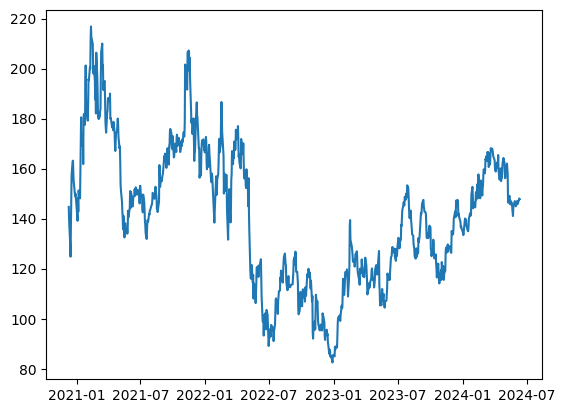

In [17]:
plt.plot(df1['ABNB'])

In [18]:
'''
CAPM

Rf= US 6m rate
Rm= S&P500

'''

'\nCAPM\n\nRf= US 6m rate\nRm= S&P500\n\n'

In [19]:
#Data manually downloaded from investing.com

# Replace 'path/to/your/file.xlsx' with the actual path to your Excel file
US6M_file_path = '/Users/bennyang/Downloads/United States 6-Month Bond Yield Historical Data.csv'

# Use pandas to read the Excel file
US6M_df = pd.read_csv(US6M_file_path)

# Print the dataframe to verify it was read correctly
print(US6M_df)


            Date  Price   Open   High    Low Change %
0     06/12/2024  5.385  5.383  5.385  5.383    0.25%
1     06/11/2024  5.372  5.380  5.391  5.372   -0.07%
2     06/10/2024  5.376  5.390  5.413  5.373   -0.16%
3     06/09/2024  5.385  5.379  5.385  5.379    0.11%
4     06/07/2024  5.379  5.352  5.390  5.337    0.65%
...          ...    ...    ...    ...    ...      ...
4809  01/09/2006  4.364  4.364  4.364  4.364    0.48%
4810  01/06/2006  4.343  4.343  4.343  4.343   -0.28%
4811  01/05/2006  4.355  4.355  4.355  4.355    0.09%
4812  01/04/2006  4.351  4.351  4.351  4.351    0.32%
4813  01/03/2006  4.337  4.337  4.337  4.337    0.23%

[4814 rows x 6 columns]


In [20]:

US6M_df['Date'] = pd.to_datetime(US6M_df['Date'], format='mixed')
US6M_df.set_index('Date',inplace=True)
US6M_df.sort_index(ascending=True,inplace=True)
US6M_df.drop(['Open','High','Low','Change %'], axis=1, inplace=True)
US6M_df.rename(columns={"Price": "US6M"},inplace=True)
US6M_df['US6M']=US6M_df['US6M']/100
print(US6M_df)

               US6M
Date               
2006-01-03  0.04337
2006-01-04  0.04351
2006-01-05  0.04355
2006-01-06  0.04343
2006-01-09  0.04364
...             ...
2024-06-07  0.05379
2024-06-09  0.05385
2024-06-10  0.05376
2024-06-11  0.05372
2024-06-12  0.05385

[4814 rows x 1 columns]


In [23]:
#Restack df3 to be of single column
Beta=df3.stack(future_stack=True).rename("Beta")

In [27]:
#Join the risk free rate to the beta dataframe
Beta_rf = pd.DataFrame(US6M_df).join(pd.DataFrame(Beta), rsuffix='Date')

In [28]:
Beta_rf

US6M      Beta
Date       Ticker                   
2006-01-03 A       0.04337  1.163252
           AAL     0.04337       NaN
           AAPL    0.04337  1.770564
           ABBV    0.04337       NaN
           ABNB    0.04337       NaN
...                    ...       ...
2024-06-11 YUM     0.05372  0.641219
           ZBH     0.05372  0.720603
           ZBRA    0.05372  1.507831
           ZTS     0.05372  1.130680
           ^GSPC   0.05372  0.002707

[2329488 rows x 2 columns]

In [29]:
#Download beta and rf data as csv if needed

Beta_rf.to_csv(path_or_buf='/Users/bennyang/Downloads/beta&rf.csv', index=True) 

In [21]:
df4 = df3.merge(US6M_df, on='Date', how='left')

In [22]:
#df4 contains the beta for all S&P 500 stocks, S&P return and US6M rate
df4

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS,^GSPC,US6M
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,NaN,NaN,0.006689,NaN,NaN,0.003603,NaN,NaN,0.048202,-0.053346,...,NaN,-0.003091,-0.010051,NaN,NaN,NaN,NaN,NaN,-0.002589,NaN
1990-01-04,NaN,NaN,0.003331,NaN,NaN,-0.001799,NaN,NaN,0.045985,-0.013793,...,NaN,-0.025079,-0.010152,NaN,NaN,NaN,NaN,NaN,-0.008650,NaN
1990-01-05,NaN,NaN,0.003316,NaN,NaN,-0.010869,NaN,NaN,0.022223,0.000000,...,NaN,-0.009569,-0.005115,NaN,NaN,NaN,NaN,NaN,-0.009804,NaN
1990-01-08,NaN,NaN,0.006601,NaN,NaN,0.005113,NaN,NaN,0.013129,0.000000,...,NaN,-0.009662,0.015267,NaN,NaN,NaN,NaN,NaN,0.004504,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-05,0.923434,1.437444,1.033126,0.328691,1.674634,0.413529,0.300921,0.958756,1.548789,1.367786,...,1.145825,0.341308,0.276797,0.980229,0.672899,0.734113,1.533333,1.137975,0.011778,0.05350
2024-06-06,0.930193,1.435287,1.030719,0.341071,1.651551,0.407366,0.287523,0.959886,1.548583,1.372798,...,1.138640,0.325550,0.276622,0.985771,0.659512,0.721459,1.532795,1.144689,-0.000200,0.05344
2024-06-07,0.924363,1.448397,1.034854,0.346260,1.669291,0.409471,0.276119,0.958895,1.554493,1.377511,...,1.139395,0.337049,0.267014,0.999376,0.665376,0.727644,1.527629,1.155212,-0.001116,0.05379


In [66]:
#df5=df4['US6M']+df4*((df2['^GSPC'].rolling(period).sum())-df4['US6M'])
#df5=((df2['^GSPC'].rolling(period).sum())-df4['US6M'])

In [67]:
#create a df5 to store the expected returns

df5=df4.copy()

In [68]:
#Loop through all the columns, then loop through all the rows (starting from period). Calculate what is the rf, beta, market return to get expected return for the stock  

for j in range (df4.shape[1]-2):                     #all columns in df4 except last 2 columns
    for i in range(1+period, len(df4)):
        try:
            rf=df4.iloc[i,-1]                        #risk-free rate on that particular day
            beta=df4.iloc[i,j]                       #beta on that particular day
            market_return=df4.iloc[i-period:i,-2].sum()
            expected_returns=rf+beta*(market_return-rf)
            df5.iloc[i,j]= expected_returns
        except IndexError:
            df5.iloc[i,j]= 0

In [69]:
#df5 contains the expected return for all S&P 500 stocks
#drop the S&P500 and US6M rate
df5.drop(['^GSPC','US6M'], axis=1,inplace=True)
df5

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,NaN,NaN,0.006689,NaN,NaN,0.003604,NaN,NaN,0.048202,-0.053346,...,NaN,-0.022273,NaN,-0.003092,-0.010050,NaN,NaN,NaN,NaN,NaN
1990-01-04,NaN,NaN,0.003331,NaN,NaN,-0.001801,NaN,NaN,0.045985,-0.013793,...,NaN,-0.009050,NaN,-0.025080,-0.010152,NaN,NaN,NaN,NaN,NaN
1990-01-05,NaN,NaN,0.003317,NaN,NaN,-0.010870,NaN,NaN,0.022224,0.000000,...,NaN,-0.004555,NaN,-0.009569,-0.005115,NaN,NaN,NaN,NaN,NaN
1990-01-08,NaN,NaN,0.006600,NaN,NaN,0.005114,NaN,NaN,0.013129,0.000000,...,NaN,0.000000,NaN,-0.009662,0.015267,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-03,0.230892,0.334362,0.255187,0.113048,0.377522,0.132142,0.108702,0.246665,0.369083,0.319774,...,0.128022,0.233318,0.274110,0.117811,0.103639,0.238828,0.182377,0.193857,0.350848,0.268975
2024-06-04,0.226190,0.320058,0.247554,0.113003,0.367883,0.131442,0.105940,0.238095,0.350585,0.311228,...,0.125990,0.227690,0.266551,0.116921,0.103852,0.234928,0.178483,0.189609,0.341368,0.264164
2024-06-05,0.216200,0.306763,0.235527,0.111412,0.348554,0.126360,0.106519,0.222423,0.326381,0.294490,...,0.121327,0.219936,0.255383,0.113635,0.102269,0.226207,0.172058,0.182843,0.323658,0.254000


In [70]:
#df6 contains the actual returns over the past 1 year
#Calculate the actual returns over the past 1 year
df6 = np.log(df1/df1.shift(period))
df6.drop(['^GSPC'], axis=1,inplace=True)
df6

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-03,0.102249,-0.220886,0.120076,0.184414,0.336896,0.027193,0.340097,-0.019605,0.113130,0.316805,...,0.163984,0.078911,-0.051894,-0.114650,0.114519,0.353023,0.091255,-0.114315,0.169409,0.051945
2024-06-04,0.090301,-0.221403,0.107717,0.204190,0.319925,0.025500,0.351054,-0.037271,0.076401,0.290216,...,0.158041,0.077503,-0.074173,-0.101640,0.105396,0.344202,0.105412,-0.110316,0.134301,0.052129
2024-06-05,0.133392,-0.229663,0.104905,0.232513,0.307496,0.034905,0.336472,-0.042832,0.088464,0.306791,...,0.150649,0.065210,-0.053300,-0.114643,0.118281,0.360337,0.114320,-0.107790,0.138309,0.098130


In [71]:
#df7 adds the expected returns to the 1 year historical realized returns
#Momentum strategy - If expected returns is high and historical returns is high, stock should outperform moving forward
df7=df5+df6
df7

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-03,0.333140,0.113475,0.375262,0.297461,0.714418,0.159335,0.448800,0.227060,0.482213,0.636579,...,0.292006,0.312228,0.222216,0.003161,0.218157,0.591851,0.273632,0.079542,0.520257,0.320920
2024-06-04,0.316491,0.098655,0.355271,0.317193,0.687808,0.156943,0.456994,0.200823,0.426986,0.601444,...,0.284031,0.305193,0.192378,0.015281,0.209248,0.579131,0.283896,0.079293,0.475668,0.316293
2024-06-05,0.349592,0.077101,0.340431,0.343925,0.656050,0.161265,0.442992,0.179592,0.414846,0.601281,...,0.271976,0.285146,0.202083,-0.001008,0.220550,0.586544,0.286378,0.075053,0.461967,0.352130


In [72]:
#df8 ranks every day the stock with the highest expected returns +realized returns
df8=df7.rank(axis=1)
df8

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-03,217.0,63.0,249.0,180.0,446.0,81.0,307.0,119.0,330.0,419.0,...,174.0,196.0,117.0,29.0,112.0,391.0,155.0,51.0,347.0,202.0
2024-06-04,211.0,61.0,244.0,212.0,447.0,81.0,326.0,110.0,305.0,416.0,...,179.0,197.0,102.0,34.0,115.0,399.0,178.0,51.0,339.0,210.0
2024-06-05,246.0,52.0,233.0,237.0,437.0,88.0,313.0,100.0,298.0,415.0,...,165.0,184.0,114.0,29.0,124.0,405.0,187.0,49.0,330.0,249.0


In [73]:
#df9 subtracts the 1 year historical realized returns from the expected returns
#Mean reversion strategy - If historical realized returns is high relative to expected returns, the stock should underperform moving forward. But if historical realized returns is poor but expected returns is high, the stock has room to outperform moving forward.
df9=df5-df6
df9

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-03,0.128643,0.555248,0.135111,-0.071366,0.040625,0.104949,-0.231395,0.266269,0.255953,0.002969,...,-0.035961,0.154407,0.326005,0.232461,-0.010880,-0.114195,0.091122,0.308172,0.181439,0.217029
2024-06-04,0.135889,0.541461,0.139837,-0.091186,0.047958,0.105942,-0.245114,0.275366,0.274184,0.021012,...,-0.032051,0.150187,0.340724,0.218562,-0.001544,-0.109274,0.073071,0.299925,0.207067,0.212034
2024-06-05,0.082808,0.536426,0.130622,-0.121101,0.041058,0.091454,-0.229953,0.265255,0.237917,-0.012301,...,-0.029321,0.154726,0.308683,0.228278,-0.016012,-0.134130,0.057738,0.290633,0.185349,0.155870


In [74]:
#df10 ranks every day the stock with the highest expected returns -realized returns
df10=df9.rank(axis=1)
df10

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-03,319.0,487.0,327.0,143.0,250.0,304.0,47.0,418.0,411.0,212.0,...,172.0,347.0,447.0,406.0,194.0,112.0,295.0,435.0,364.0,392.0
2024-06-04,321.0,483.0,326.0,124.0,252.0,305.0,40.0,425.0,422.0,230.0,...,172.0,339.0,452.0,395.0,199.0,107.0,278.0,435.0,384.0,386.0
2024-06-05,300.0,486.0,332.0,116.0,261.0,305.0,52.0,427.0,411.0,200.0,...,188.0,355.0,447.0,406.0,198.0,108.0,278.0,437.0,379.0,358.0
